In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import random
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.datasets import fetch_openml, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD
from wisard.utils import untie, get_random_permutation, permute_dataset_bits
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search

from keras.datasets import mnist, cifar10, fashion_mnist

%matplotlib inline

2022-09-06 20:26:59.498290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 20:26:59.498356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def pick_a_sample(target: int, X, y, shape: tuple):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape(shape)


def display_samples(X,
                    y,
                    rows: int = 2,
                    columns: int = 5,
                    figsize=(16, 8),
                    vmin: float = None,
                    vmax: float = None,
                    shape: tuple = (28, 28),
                    cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(rows):
        for j in range(columns):
            im = axs[i, j].imshow(
                pick_a_sample(target=columns * i + j, X=X, y=y, shape=shape),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()

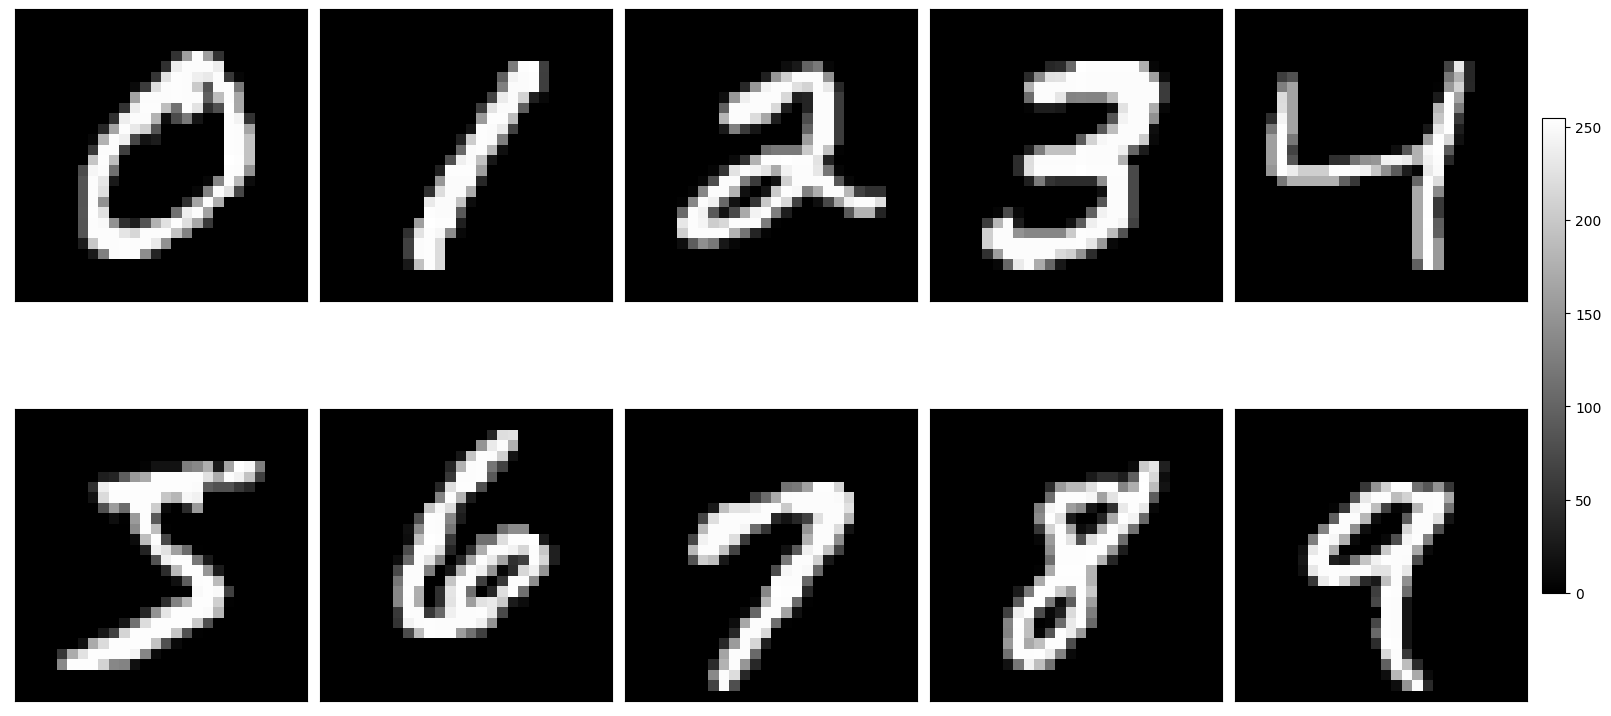

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
display_samples(x_train, y_train, vmin=0, vmax=255)

In [8]:
output_path = Path("mnist_shuffled.pkl")
with output_path.open("rb") as f:
    (x_train, y_train), (x_test, y_test) = pickle.load(f)
    
print(x_train.shape)

(60000, 784)


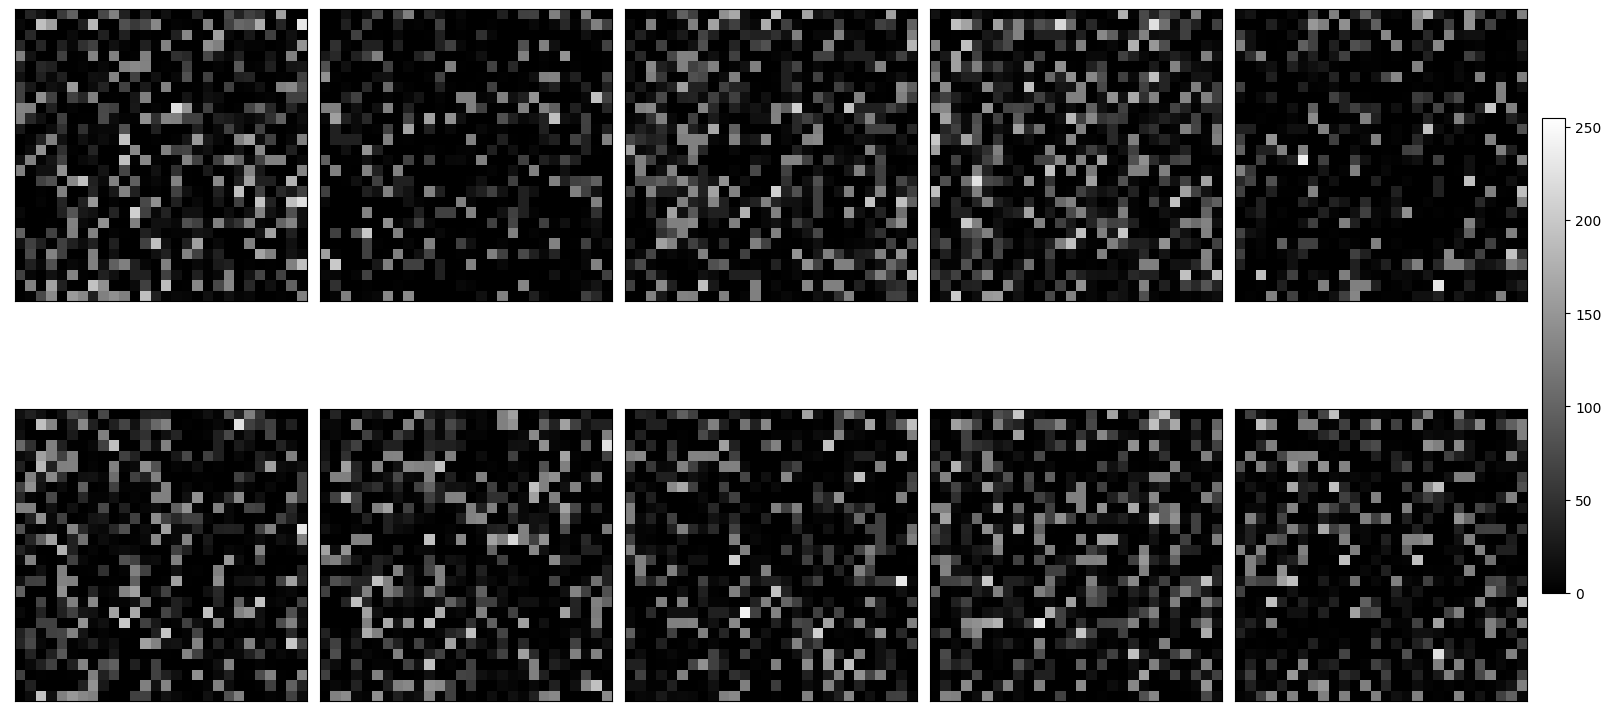

In [10]:
import pickle
from pathlib import Path

output_path = Path("mnist.pkl")
with output_path.open("wb") as f:
    pickle.dump(((x_train, y_train), (x_test, y_test)), f)

In [6]:
np.random.seed(0)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
print(permutation)

x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

output_path = Path("mnist_shuffled.pkl")
with output_path.open("wb") as f:
    pickle.dump(((x_train, y_train), (x_test, y_test)), f)

[ 949 5336  634 ... 1653 2607 2732]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 92153.95it/s]


In [5]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=24)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5866.54it/s]


# Creating wisard

In [6]:
shared_rand_vals = True  # not used...
input_size = x_train[0].size
num_classes = 10
tuple_size = 24
unit_entries = 1  # Only used for BloomFilter
unit_hashes = 1  # Only used for BloomFilter
input_idxs = np.random.shuffle(np.arange(input_size))  # Order to select elements
# input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()
randomize = False  # Randomize selection order?

In [7]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False,
    use_dict=True
)

Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT


In [8]:
model.fit(x_train, y_train)

Training model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [06:01<00:00, 166.13it/s]


In [9]:
y_pred = model.predict(x_test, y_test, bleach=50, use_tqdm=True)
y_pred, ties = untie(y_pred, use_tqdm=True)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Untieing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 2262299.89it/s]

0.7969


## Randomized inputs

In [10]:
import random
import sys
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD, model_from_coded_mental_image
from wisard.utils import untie, get_random_permutation, permute_dataset_bits
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search

from wisard.data import IrisDataset
from keras.datasets import mnist, fashion_mnist


%matplotlib inline

In [9]:
def sample_digit(target: int, X, y):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape((28, 28))


def display_mnist_digits(X,
                         y,
                         figsize=(16, 8),
                         vmin: float = None,
                         vmax: float = None,
                         cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(2):
        for j in range(5):
            im = axs[i, j].imshow(
                sample_digit(target=5 * i + j, X=X, y=y),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()


def do_train_and_evaluate(x_train,
                          y_train,
                          x_test,
                          y_test,
                          tuple_size: int,
                          input_indexes: List[int] = None,
                          shuffle_indexes: bool = True,
                          bleach: Union[int, str] = "auto",
                          **kwargs):
    num_classes = len(np.unique(y_train))

    print(" ----- Training model ----- ")            

    if input_indexes is None:
        input_indexes = np.arange(x_train[0].size)
    if shuffle_indexes:
        np.random.shuffle(input_indexes)
    print(f"Using input_indexes: {input_indexes}")

    model = WiSARD(num_inputs=x_train[0].size,
                   num_classes=num_classes,
                   unit_inputs=tuple_size,
                   unit_entries=1,
                   unit_hashes=1,
                   input_idxs=input_indexes,
                   shared_rand_vals=False,
                   randomize=False,
                   use_dict=True)

    model.fit(x_train, y_train)
    max_bleach = model.max_bleach()
    print(f"Max bleach is: {max_bleach}\n")

    print(" ----- Evaluating model ----- ")

    if isinstance(bleach, int):
        y_pred = model.predict(x_test, y_test, bleach=bleach, use_tqdm=True)
        y_pred, ties = untie(y_pred, use_tqdm=False)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}")
    elif bleach == "auto":
        bleach = find_best_bleach_bin_search(model,
                                           X=x_test,
                                           y=y_test,
                                           min_bleach=1,
                                           max_bleach=max_bleach,
                                           **kwargs)
    else:
        raise ValueError(f"Invalid value for bleach: '{bleach}'")

    return model, bleach

NameError: name 'Union' is not defined

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

array([4301,  267, 5028, ..., 4659, 3044,  345])

In [14]:
x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 90177.98it/s]


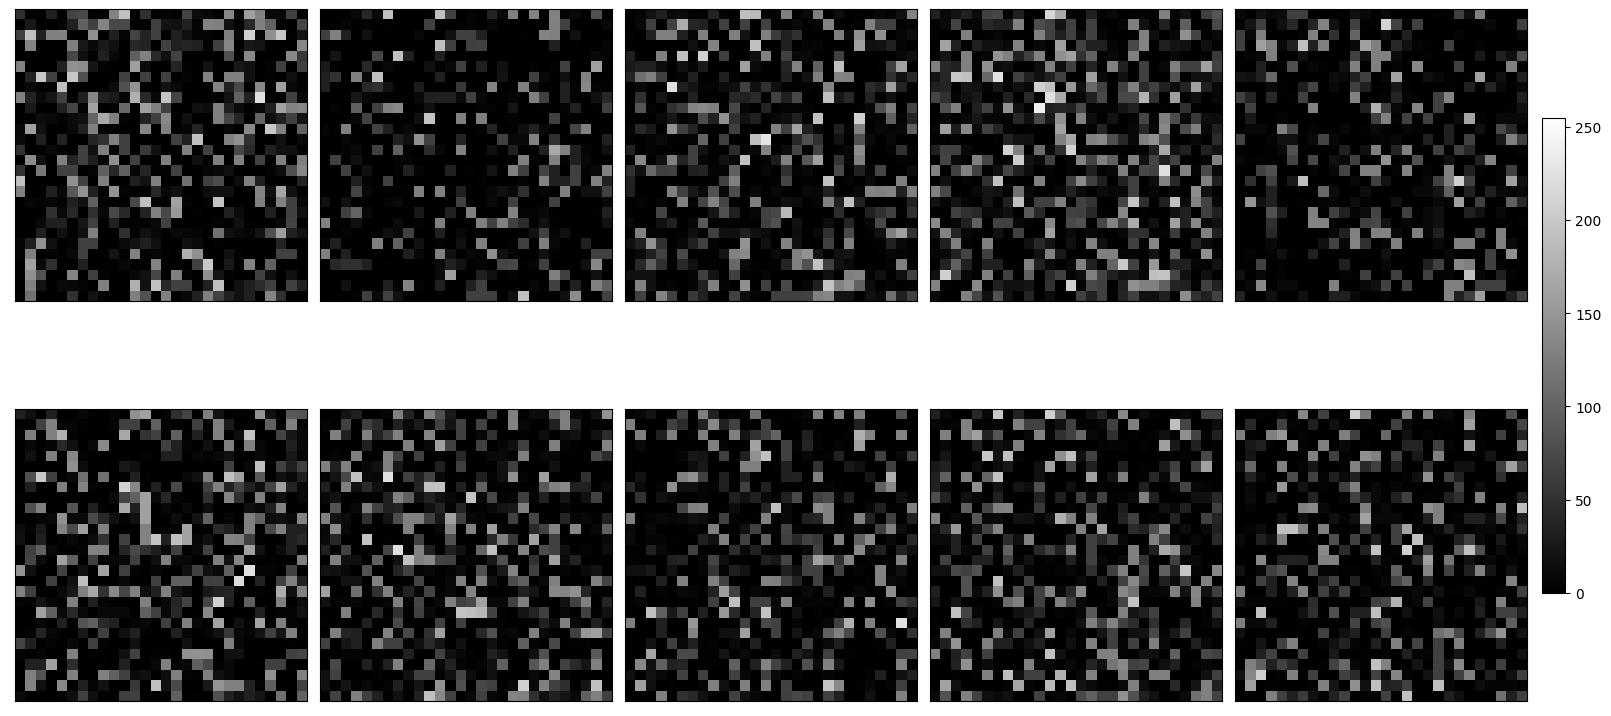

In [15]:
display_mnist_digits(x_train, y_train, vmin=0, vmax=255)

In [16]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=24)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10506.54it/s]


In [17]:
input_size = x_train[0].size
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()

model, bleach = do_train_and_evaluate(x_train,
                                      y_train,
                                      x_test,
                                      y_test,
                                      input_indexes=input_idxs,
                                      tuple_size=24,
                                      bleach=50,
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [    0   784  1568 ... 17247 18031 18815]
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT


Training model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [05:43<00:00, 174.89it/s]


Max bleach is: 6740

 ----- Evaluating model ----- 


Evaluating model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:33<00:00, 17.43it/s]


Accuracy: 0.789
Best bleach: 50


In [ ]:
best_bleach = find_best_bleach_bayesian(model,
                                        X=x_test,
                                        y=y_test,
                                        min_bleach=1,
                                        max_bleach=model.max_bleach())

|   iter    |  target   |  bleach   |
-------------------------------------


In [10]:
print(best_bleach)

1.0


In [11]:
best_bleach = find_best_bleach_bin_search(model,
                                          X=x_test,
                                          y=y_test,
                                          min_bleach=1,
                                          max_bleach=model.max_bleach())

Testing with bleach=1686


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1698305.06it/s]


[b=1686] Accuracy=0.203, ties=2563
Testing with bleach=3371


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1767734.65it/s]


[b=3371] Accuracy=0.126, ties=1141
Testing with bleach=5056


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1743993.35it/s]


[b=5056] Accuracy=0.114, ties=273
Testing with bleach=844


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1769972.57it/s]


[b=844] Accuracy=0.440, ties=780
Testing with bleach=1686
[b=1686] Accuracy=0.203
Testing with bleach=2528


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1641092.42it/s]


[b=2528] Accuracy=0.155, ties=1969
Testing with bleach=423


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1347134.74it/s]


[b=423] Accuracy=0.666, ties=220
Testing with bleach=844
[b=844] Accuracy=0.440
Testing with bleach=1265


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1719399.85it/s]


[b=1265] Accuracy=0.284, ties=2148
Testing with bleach=213


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1535587.61it/s]


[b=213] Accuracy=0.769, ties=105
Testing with bleach=423
[b=423] Accuracy=0.666
Testing with bleach=633


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1687034.03it/s]


[b=633] Accuracy=0.549, ties=401
Testing with bleach=108


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1676782.60it/s]


[b=108] Accuracy=0.831, ties=69
Testing with bleach=213
[b=213] Accuracy=0.769
Testing with bleach=318


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1697617.68it/s]


[b=318] Accuracy=0.726, ties=171
Testing with bleach=56


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1683107.54it/s]


[b=56] Accuracy=0.874, ties=37
Testing with bleach=108
[b=108] Accuracy=0.831
Testing with bleach=160


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1669308.29it/s]


[b=160] Accuracy=0.801, ties=74
Testing with bleach=30


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1593338.40it/s]


[b=30] Accuracy=0.902, ties=30
Testing with bleach=56
[b=56] Accuracy=0.874
Testing with bleach=82


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1558815.18it/s]


[b=82] Accuracy=0.849, ties=48
Testing with bleach=17


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1619797.64it/s]


[b=17] Accuracy=0.916, ties=31
Testing with bleach=30
[b=30] Accuracy=0.902
Testing with bleach=43


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1675911.62it/s]


[b=43] Accuracy=0.888, ties=32
Testing with bleach=11


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1508579.65it/s]


[b=11] Accuracy=0.921, ties=35
Testing with bleach=17
[b=17] Accuracy=0.916
Testing with bleach=23


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1614311.45it/s]


[b=23] Accuracy=0.910, ties=32
Testing with bleach=8


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1577517.68it/s]


[b=8] Accuracy=0.926, ties=37
Testing with bleach=11
[b=11] Accuracy=0.921
Testing with bleach=14


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1713079.56it/s]


[b=14] Accuracy=0.919, ties=28
Testing with bleach=7


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1657434.60it/s]


[b=7] Accuracy=0.926, ties=36
Testing with bleach=8
[b=8] Accuracy=0.926
Testing with bleach=9


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1658745.55it/s]

[b=9] Accuracy=0.924, ties=30
Best bleach: 8....


In [12]:
print(best_bleach)

8
